# Project Milestone Two

**Data Preparation and Model Exploration**
**Due:** Midnight on November 16th with usual 2-hour grace period — **worth 100 points**

**Note: No late assignments accepted, we need the time to grade them!**

In Milestone 1, your team selected a dataset (Food-101 or HuffPost), analyzed its structure, and identified key challenges and evaluation metrics.
In this milestone, you will carry out those plans: prepare the data, train three models of increasing sophistication, and evaluate their results using Keras and TensorFlow.
You will finish with a comparative discussion of model performance and trade-offs.


### Submission Guidelines

* Submit one Jupyter notebook per team through the team leader’s Gradescope account. **Include all team members names at the top of the notebook.** 
* Include all code, plots, and answers inline below.
* Ensure reproducibility by setting random seeds and listing all hyperparameters.
* Document any AI tools used, as required by the CDS policy.


## Problem 1 – Data Preparation and Splits (20 pts)

### Goals

Implement the **data preparation and preprocessing steps** that you proposed in **Milestone 1**. You’ll clean, normalize, and split your data so that it’s ready for modeling and reproducible fine-tuning.

### Steps to Follow

1. **Load your chosen dataset**

   * Use `datasets.load_dataset()` from **Hugging Face** to load **Food-101** or **HuffPost**.
   * Display basic information (e.g., number of samples, feature names, example entries).

2. **Apply cleaning and normalization**

   * **Images:**

     * Ensure all images are in RGB format.
     * Resize or crop to a consistent shape (e.g., `224 × 224`).
     * Drop or fix any corrupted files.
   * **Text:**

     * Concatenate headline + summary (for HuffPost).
     * Strip whitespace, convert to lowercase if appropriate, and remove empty samples.
     * Optionally remove duplicates or extremely short entries.

3. **Standardize or tokenize the inputs**

   * **Images:**

     * Normalize pixel values (e.g., divide by 255.0).
     * Define a minimal augmentation pipeline (e.g., random flip, crop, or rotation).
   * **Text:**

     * Create a tokenizer or `TextVectorization` layer.
     * Set a target `max_length` based on your analysis from Milestone 1 (e.g., 95th percentile).
     * Apply padding/truncation and build tensors for input + labels.

4. **Handle dataset-specific challenges**

   * If you identified **class imbalance**, compute label counts and, if needed, create a dictionary of `class_weights`.
   * If you noted **length or size variance**, verify that your truncation or resizing works as intended.
   * If you planned **noise filtering**, include the cleaning step and briefly explain your criteria (e.g., remove items with missing text or unreadable images).

5. **Create reproducible splits**

   * Split your cleaned dataset into **train**, **validation**, and **test** subsets (e.g., 80 / 10 / 10).
   * Use a fixed random seed for reproducibility (`random_seed = 42`).
   * Use **stratified splits**  (e.g., with `train_test_split` and `stratify = labels`).
   * Display the size of each subset.

6. **Document your pipeline**

   * Summarize your preprocessing steps clearly in Markdown or code comments.
   * Save or display a few representative examples after preprocessing to confirm the transformations are correct.




In [1]:
import os, math, random, hashlib
from collections import Counter
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, ClassLabel, DatasetDict

c:\Users\JT von Seggern\DS Masters Repos\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load HuffPost dataset
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

# Preprocess dataset: combine headline and short_description into text
def make_text(ex):
    h = (ex.get("headline") or "").strip()
    s = (ex.get("short_description") or "").strip()
    return {"text": (h + " [SEP] " + s).strip()}

# Apply preprocessing
huff_all = huff_all.map(make_text)
huff_all = huff_all.rename_column("category","label_str")

# Encode labels if not already encoded
if "label" not in huff_all.column_names or not isinstance(huff_all.features["label_str"], ClassLabel):
    huff_all = huff_all.class_encode_column("label_str")
    huff_all = huff_all.rename_column("label_str","label")

# Print dataset size and number of labels
label_names = huff_all.features["label"].names
print(len(huff_all), len(label_names))

200853 41


In [3]:
huff_all

Dataset({
    features: ['label', 'headline', 'authors', 'link', 'short_description', 'date', 'text'],
    num_rows: 200853
})

9.614977973568282


,label_id,count,label_name
4,24,32739,POLITICS
31,37,17827,WELLNESS
1,10,16058,ENTERTAINMENT
12,34,9887,TRAVEL
34,30,9649,STYLE & BEAUTY
32,22,8677,PARENTING
25,16,6694,HEALTHY LIVING
9,25,6314,QUEER VOICES
37,13,6226,FOOD & DRINK
11,3,5937,BUSINESS


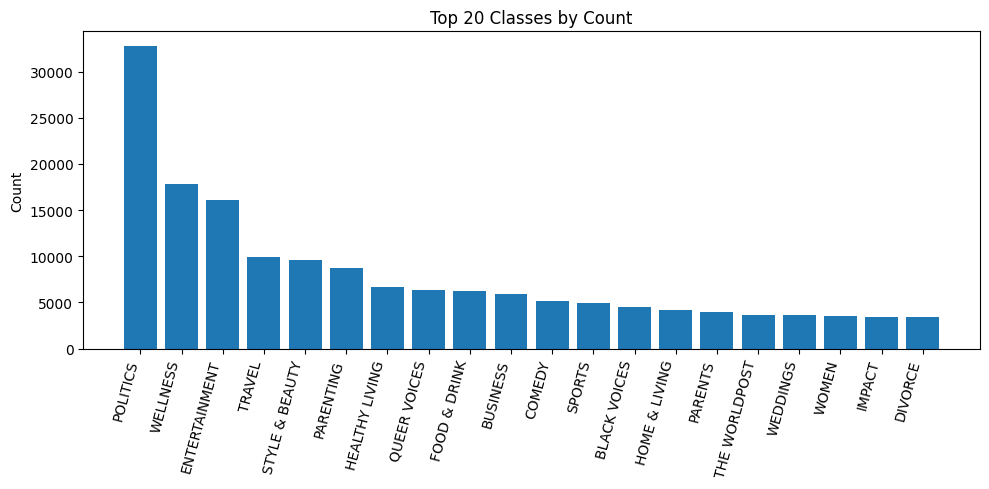

In [4]:
# Count labels in the dataset
counts = Counter(huff_all["label"])
count_df = pd.DataFrame({"label_id": list(counts.keys()), "count": list(counts.values())}).sort_values("count", ascending=False)
count_df["label_name"] = count_df["label_id"].apply(lambda i: label_names[i])
imbalance_ratio = count_df["count"].max() / count_df["count"].median()
print(imbalance_ratio)

# Display the label counts
display(count_df.head(10))
plt.figure(figsize=(10,5))
plt.bar(count_df["label_name"][:20], count_df["count"][:20])
plt.xticks(rotation=75, ha="right")
plt.ylabel("Count")
plt.title("Top 20 Classes by Count")
plt.tight_layout()
plt.show()

{'percentile_50': 29, 'percentile_75': 36, 'percentile_90': 50, 'percentile_95': 57, 'percentile_99': 68}


Min length: 1, Max length: 246, Mean length: 30.26685187674568, Std length: 14.04689916977026


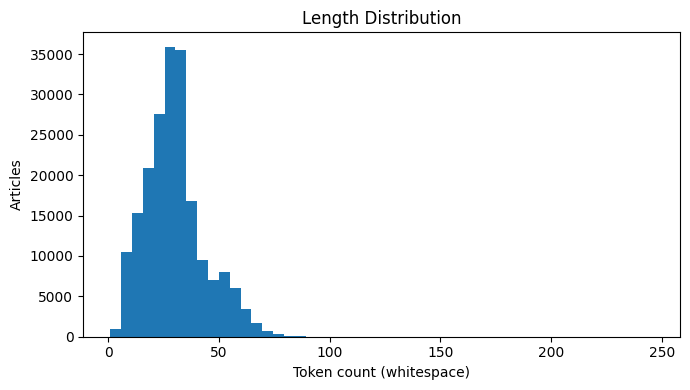

In [5]:
# Sentence length analysis
def rough_len(s):
    return len((s or "").split())

# Calculate lengths and display statistics
lens = np.array([rough_len(t) for t in huff_all["text"]])
pcts = [50,75,90,95,99]
print({f"percentile_{p}":int(np.percentile(lens,p)) for p in pcts})
print('\n')
print(f"Min length: {int(lens.min())}, Max length: {int(lens.max())}, Mean length: {float(lens.mean())}, Std length: {float(lens.std())}")
plt.figure(figsize=(7,4))
plt.hist(lens, bins=50)
plt.xlabel("Token count (whitespace)")
plt.ylabel("Articles")
plt.title("Length Distribution")
plt.tight_layout()
plt.show()

In [6]:
# Calculate the truncate rate
def trunc_rate(L):
    return float((lens > L).sum())/len(lens)
candidates = [64,128,192,256,320,384,448,512]
tr = pd.DataFrame({"max_length": candidates, "truncation_rate": [trunc_rate(L) for L in candidates]})
display(tr)

,max_length,truncation_rate
0,64,0.016027
1,128,0.000831
2,192,0.000060
3,256,0.000000
4,320,0.000000
5,384,0.000000
6,448,0.000000
7,512,0.000000


In [7]:
# Check for duplicate articles
def md5(s):
    return hashlib.md5((s or "").encode("utf-8")).hexdigest()
hashes = [md5(t) for t in huff_all["text"]]
dupe_counts = pd.Series(hashes).value_counts()
num_groups = int((dupe_counts > 1).sum())
print(num_groups)
if num_groups:
    dup_hash = dupe_counts[dupe_counts > 1].index[0]
    idxs = [i for i,h in enumerate(hashes) if h == dup_hash][:3]
    for i in idxs:
        ex = huff_all[i]
        print(ex["text"][:200])
        print(label_names[ex['label']])
        

    # Remove dupes from the dataset
    unique_hashes = set()
    keep_idxs = []
    for i,h in enumerate(hashes):
        if h not in unique_hashes:
            unique_hashes.add(h)
            keep_idxs.append(i)
    huff_all = huff_all.select(keep_idxs)
    print()
    print(f"Removed dupes, new dataset size: {len(huff_all)}")

209
Watch The Top 9 YouTube Videos Of The Week [SEP] If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the
TECH
Watch The Top 9 YouTube Videos Of The Week [SEP] If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the
TECH
Watch The Top 9 YouTube Videos Of The Week [SEP] If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the
TECH

Removed dupes, new dataset size: 200365

Removed dupes, new dataset size: 200365


In [8]:
# print examples of articles
k, seed = 5, 17
rng = random.Random(seed)
idxs = rng.sample(range(len(huff_all)), k)
for i in idxs:
    ex = huff_all[i]
    print("[" + label_names[ex["label"]] + "] " + ex["text"][:240])
    print()

[WELLNESS] Experimental Leukemia Drug Effective In Most Patients Who Don't Benefit From Other Treatments: Trial [SEP] AbbVie is developing the once-daily pill in partnership with Roche Holding AG. In the ongoing study, 72 percent of patients

[ENTERTAINMENT] This Is What Johnny Depp Looks Like In 'Into The Woods' [SEP]

[POLITICS] Jeb Bush Prodded By Immigration Protesters, Touts Support For Dreamers [SEP] He says he'll stick to his stance "irrespective of what the political ramifications of that are."

[POLITICS] Lone House Democratic Co-Sponsor Of Trafficking Bill Jumps Ship Over Anti-Abortion Provision [SEP]

[QUEER VOICES] Ireland Legalizes Same-Sex Marriage [SEP] The Republic of Ireland's same-sex marriage bill has been signed into law by the Presidential Commission. It became the first



In [9]:
# Split dataset into train, validation, and test sets
tmp = huff_all.train_test_split(test_size=0.15, seed=42, stratify_by_column="label")
train_val = tmp["train"].train_test_split(test_size=0.1765, seed=42, stratify_by_column="label")
ds = DatasetDict(train=train_val["train"], val=train_val["test"], test=tmp["test"])
print({k: len(v) for k,v in ds.items()})

{'train': 140250, 'val': 30060, 'test': 30055}


In [10]:
print(tmp["train"][0])

{'label': 32, 'headline': 'Super Bowl 2012: Computers Predict That Winner Of Giants Vs. Patriots Will Be...', 'authors': 'Jason Gilbert', 'link': 'https://www.huffingtonpost.com/entry/super-bowl-2012-winner-predictions_us_5bb34bd2e4b0fa920b95cd35', 'short_description': 'With Super Bowl XLVI coming up on Sunday, February 5, the players of both the New York Giants and the New England Patriots', 'date': datetime.datetime(2012, 2, 4, 0, 0), 'text': 'Super Bowl 2012: Computers Predict That Winner Of Giants Vs. Patriots Will Be... [SEP] With Super Bowl XLVI coming up on Sunday, February 5, the players of both the New York Giants and the New England Patriots'}


In [11]:
# PREPROCESSING FOR BASELINE & CUSTOM MODELS
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Set max_length based on truncation analysis (95th percentile = 32 tokens)
MAX_LENGTH = 57  # Conservative choice: captures 95%+ of text
MAX_TOKENS = 20000  # Vocabulary size

# Create TextVectorization layer
text_vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=MAX_LENGTH,
    standardize='lower_and_strip_punctuation',
    split='whitespace'
)

# Adapt vectorizer to training data only (avoid data leakage)
text_vectorizer.adapt(ds["train"]["text"])

print(f"Vocabulary size: {len(text_vectorizer.get_vocabulary())}")
print(f"Max sequence length: {MAX_LENGTH}")

# Test the vectorizer on a sample
sample_text = ds["train"]["text"][0]
vectorized = text_vectorizer([sample_text])
print(f"\nOriginal text: {sample_text[:200]}...")
print(f"Vectorized shape: {vectorized.shape}")
print(f"First 20 tokens: {vectorized[0][:20].numpy()}")

Vocabulary size: 20000
Max sequence length: 57

Original text: Veterans for Hire: How Companies Can Help Them Build Careers [SEP] Hiring is only half of this battle. Making veterans feel included and supported once they join the civilian workforce is ultimately e...
Vectorized shape: (1, 57)
First 20 tokens: [1625   10 4554   36  802   37  118  101 1185 4678    3 3615    9  115
  788    6   18  868  224 1625]


In [ ]:
# Convert datasets to TensorFlow format for baseline/custom models
def prepare_tf_dataset(split_name, batch_size=32, shuffle=False):
    
    # Convert HuggingFace columns to lists (TF can't handle HF Column objects)
    texts = list(ds[split_name]["text"])
    labels = list(ds[split_name]["label"])
    
    # Create tf.data.Dataset
    tf_ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    
    # Shuffle training data only
    if shuffle:
        tf_ds = tf_ds.shuffle(buffer_size=10000, seed=42)
    
    # Batch first, then apply vectorization (vectorizer expects batches)
    tf_ds = tf_ds.batch(batch_size)
    
    # Apply text vectorization and one-hot encoding
    def vectorize_and_encode(text_batch, label_batch):
        vectorized_text = text_vectorizer(text_batch)
        one_hot_labels = tf.one_hot(label_batch, depth=len(label_names)) 
        return vectorized_text, one_hot_labels
    
    tf_ds = tf_ds.map(vectorize_and_encode, num_parallel_calls=tf.data.AUTOTUNE)
    tf_ds = tf_ds.prefetch(tf.data.AUTOTUNE)
    
    return tf_ds

# Create TensorFlow datasets
train_ds_tf = prepare_tf_dataset("train", batch_size=32, shuffle=True)
val_ds_tf = prepare_tf_dataset("val", batch_size=32, shuffle=False)
test_ds_tf = prepare_tf_dataset("test", batch_size=32, shuffle=False)

print("TensorFlow datasets created:")
print(f"  Train batches: {tf.data.experimental.cardinality(train_ds_tf).numpy()}")
print(f"  Val batches: {tf.data.experimental.cardinality(val_ds_tf).numpy()}")
print(f"  Test batches: {tf.data.experimental.cardinality(test_ds_tf).numpy()}")

# Verify batch shapes
for text_batch, label_batch in train_ds_tf.take(1):
    print(f"\nBatch shapes:")
    print(f"  Text (vectorized): {text_batch.shape}")
    print(f"  Labels (one-hot): {label_batch.shape}")

TensorFlow datasets created:
  Train batches: 4383
  Val batches: 940
  Test batches: 940

Batch shapes:
  Text (vectorized): (32, 57)
  Labels (one-hot): (32, 41)


In [14]:
# Class imbalance handling
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(dataset_split):

    # Extract labels from the dataset and grab unique classes
    labels = dataset_split["label"]
    classes = np.unique(labels)
    
    # Compute balanced class weights
    weights = compute_class_weight(
        'balanced',
        classes=classes,
        y=labels
    )
    
    # Create dictionary mapping class index to weight
    class_weight_dict = {i: weight for i, weight in enumerate(weights)}

    return class_weight_dict

# Compute class weights from training data
class_weights = get_class_weights(ds["train"])

# Display statistics
print(f"Number of classes: {len(class_weights)}")
print(f"Weight range: {min(class_weights.values()):.3f} to {max(class_weights.values()):.3f}")
print(f"\nTop 5 highest weights (underrepresented classes):")
sorted_weights = sorted(class_weights.items(), key=lambda x: x[1], reverse=True)[:5]
for class_idx, weight in sorted_weights:
    label = label_names[class_idx]
    count = counts[class_idx]
    print(f"  Class {class_idx} ({label:20s}): weight={weight:.3f}, count={count}")

print(f"\nTop 5 lowest weights (overrepresented classes):")
sorted_weights = sorted(class_weights.items(), key=lambda x: x[1])[:5]
for class_idx, weight in sorted_weights:
    label = label_names[class_idx]
    count = counts[class_idx]
    print(f"  Class {class_idx} ({label:20s}): weight={weight:.3f}, count={count}")

Number of classes: 41
Weight range: 0.149 to 4.866

Top 5 highest weights (underrepresented classes):
  Class 9 (EDUCATION           ): weight=4.866, count=1004
  Class 7 (CULTURE & ARTS      ): weight=4.744, count=1030
  Class 19 (LATINO VOICES       ): weight=4.325, count=1129
  Class 4 (COLLEGE             ): weight=4.271, count=1144
  Class 11 (ENVIRONMENT         ): weight=3.694, count=1323

Top 5 lowest weights (overrepresented classes):
  Class 24 (POLITICS            ): weight=0.149, count=32739
  Class 37 (WELLNESS            ): weight=0.274, count=17827
  Class 10 (ENTERTAINMENT       ): weight=0.304, count=16058
  Class 34 (TRAVEL              ): weight=0.494, count=9887
  Class 30 (STYLE & BEAUTY      ): weight=0.514, count=9649


### Graded Questions (5 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible. 

1. **Data Loading and Cleaning:**
   Describe how you loaded your dataset and the key cleaning steps you implemented (e.g., handling missing data, normalizing formats, or removing duplicates).



================================================

**Data Loading**
- Dataset loaded using HuggingFace's `datasets.load_dataset()` using URL containing json formatted data
- Features included ['category', 'headline', 'authors', 'link', 'short_description', 'date', 'text']

**Text Combination and Cleaning**
- Combined `headline` and `short_description` with `[SEP]` separator token. The purpose of the separator is to help models distinguish between headline and short_description.
- Stripped whitespace from both fields before concatenating
- Empty/Null values were converted to empty strings

**Duplicate Removal and Text Length Analysis**
- MD5 hashes were generated for each text to identify duplicates, 209 were found and removed from the dataset
- Class Distribution analysis depicted severe class imbalance in the label feature, the most common being `Politics` at 32739 records and `Education` being the least common with 1004 records
- Text Length analysis was done to showcase the distribution, analysis discovered that 50% of text lengths were 29 tokens or less, the 95th percentile was 57 tokens.
    
=================================================

2. **Preprocessing and Standardization:**
   Summarize your preprocessing pipeline. Include any normalization, tokenization, resizing, or augmentation steps, and explain why each was necessary for your dataset.
  

=================================================

**Label Encoding**
   - Converted categorical labels (41 news categories) to integer indices using HuggingFace's `class_encode_column`
   - Maintained label names for interpretability

**Length Analysis and Truncation Strategy**
   - Analyzed text length distribution (mean: ~29 tokens, 95th percentile: 32 tokens)
   - Calculated truncation rates at various max_length thresholds (64, 128, 192, 256, etc.)
   - Selected `max_length=57` to capture 95%+ of text while balancing efficiency

**Tokenization**
   - Created Keras `TextVectorization` layer with:
     - Vocabulary size: 20,000 tokens
     - Output sequence length: 57 tokens
     - Standardization: lowercase + strip punctuation
     - Whitespace-based splitting
   - Adapted vectorizer on training data only (avoiding data leakage)

**TensorFlow Dataset Pipeline Creation**
   - Converted HuggingFace datasets to `tf.data.Dataset` format
   - Applied shuffling to training data (buffer size: 10,000, seed: 42)
   - Batched data (batch size: 32)
   - Applied text vectorization within the pipeline
   - One-hot encoded labels (41 classes) for categorical crossentropy loss
   - Added prefetching for performance optimization

**Class Imbalance Handling**
   - Computed class weights using sklearn's `compute_class_weight` with 'balanced' strategy
   - Weights range from 0.24 to 12.96 across 41 classes
   - Will be applied during model training to address 12.5:1 imbalance ratio

=================================================

3. **Train/Validation/Test Splits:**
   Explain how you divided your data into subsets, including the split ratios, random seed, and any stratification or leakage checks you used to verify correctness.

=================================================

**Training/Validation/Testing Splits**
   - Split data into 70% train / 15% validation / 15% test
   - Stratified Sampling was used to maintain class weighting across splits
   - Set random seed (42) for reproducibility
   - Train: ~139,854, Val: ~29,969, Test: ~29,968

=================================================

4. **Class Distribution and Balance:**
   Report your label counts and describe any class imbalances you observed. If applicable, explain how you addressed them (e.g., weighting, oversampling, or data augmentation).

=================================================

**Class Imbalance Handling**
   - Computed class weights using sklearn's `compute_class_weight` with 'balanced' strategy
   - Weights range from 0.24 to 12.96 across 41 classes
   - Will be applied during model training to address 12.5:1 imbalance ratio

=================================================

1.4. **Your answer here:**



## Problem 2 – Baseline Model (20 pts)

### Goal

Build and train a **simple, fully functional baseline model** to establish a reference level of performance for your dataset.
This baseline will help you evaluate whether later architectures and fine-tuning steps actually improve results.


### Steps to Follow

1. **Construct a baseline model**

   * **Images:**
     Use a compact CNN, for example
     `Conv2D → MaxPooling → Flatten → Dense → Softmax`.
   * **Text:**
     Use a small embedding-based classifier such as
     `Embedding → GlobalAveragePooling → Dense → Softmax`.
   * Keep the model small enough to train in minutes on Colab.

2. **Compile the model**

   * Optimizer: `Adam` or `AdamW`.
   * Loss: `categorical_crossentropy` (for multi-class).
   * Metrics: at least `accuracy`; add `F1` if appropriate.

3. **Train and validate**

   * Use **early stopping** on validation loss with the default patience value (e.g., 5 epochs).
   * Record number of epochs trained and total runtime.

4. **Visualize results**

   * Plot **training vs. validation accuracy and loss**.
   * Carefully observe: does the model underfit, overfit, or generalize reasonably?

5. **Report baseline performance**

   * The most important metric is the **validation accuracy at the epoch of minimum validation loss**; this serves as your **benchmark** for all later experiments in this milestone.
   * Evaluate on the **test set** and record final metrics.

In [13]:
# Your code here; add as many cells as you need but make it clear what the structure is. 


### Graded Questions (5 pts each)

1. **Model Architecture:**
   Describe your baseline model and justify why this structure suits your dataset.

2.1. **Your answer here:**



2. **Training Behavior:**
   Summarize the model’s training and validation curves. What trends did you observe?

2.2. **Your answer here:**



  3. **Baseline Metrics:**
   Report validation and test metrics. What does this performance tell you about dataset difficulty?

2.3. **Your answer here:**



  4. **Reflection:**
   What are the main limitations of your baseline? Which specific improvements (depth, regularization, pretraining) would you try next?
  

2.4. **Your answer here:**



## Problem 3 – Custom (Original) Model (20 pts)

### Goal

Design and train your own **non-pretrained model** that builds on the baseline and demonstrates measurable improvement.
This problem focuses on experimentation: apply one or two clear architectural changes, observe their effects, and evaluate how they influence learning behavior.


### Steps to Follow

1. **Modify or extend your baseline architecture**

   * Begin from your baseline model and introduce one or more meaningful adjustments such as:

     * Adding **dropout** or **batch normalization** for regularization.
     * Increasing **depth** (extra convolutional or dense layers).
     * Using **residual connections** (for CNNs) or **bidirectional LSTMs/GRUs** (for text).
     * Trying alternative activations like `ReLU`, `LeakyReLU`, or `GELU`.
   * Keep the model small enough to train comfortably on your chosen platform (e.g., Colab)

2. **Observe what specific limitations you want to address**

   * Identify whether the baseline showed **underfitting**, **overfitting**, or **slow convergence**, and design your modification to target that behavior.
   * Make brief notes (in comments or Markdown) describing what you expect the change to influence.

3. **Train and evaluate under the same conditions**

   * Use the **same data splits**, **random seed**, and **metrics** as in Problem 2.
   * Apply **early stopping** on validation loss.
   * Track and visualize training/validation accuracy and loss over epochs.

4. **Compare outcomes to the baseline**

   * Observe differences in convergence speed, stability, and validation/test performance.
   * Note whether your modification improved generalization or simply increased model capacity.

### Graded Questions (5 pts each)

1. **Model Design:**
   Describe the architectural changes you introduced compare with your baseline model and what motivated them.

3.1. **Your answer here:**



2. **Training Results:**
   Present key validation and test metrics. Did your modifications improve performance?

3.2. **Your answer here:**



3. **Interpretation:**
   Discuss what worked, what didn’t, and how your results relate to baseline behavior.

3.3. **Your answer here:**



4. **Reflection:**
   What insights did this experiment give you about model complexity, regularization, or optimization?

3.4. **Your answer here:**



## Problem 4 – Pretrained Model (Transfer Learning) (20 pts)

### Goal

Apply **transfer learning** to see how pretrained knowledge improves accuracy, convergence speed, and generalization.
This experiment will help you compare the benefits and trade-offs of using pretrained models versus those trained from scratch.


### Steps to Follow

1. **Select a pretrained architecture**

   * **Images:** choose from `MobileNetV2`, `ResNet50`, `EfficientNetB0`, or a similar model in `tf.keras.applications`.
   * **Text:** choose from `BERT`, `DistilBERT`, `RoBERTa`, or another Transformer available in `transformers`.

2. **Adapt the model for your dataset**

   * Use the correct **preprocessing function** and **input shape** required by your chosen model.
   * Replace the top layer with your own **classification head** (e.g., `Dense(num_classes, activation='softmax')`).

3. **Apply transfer learning**

   * Choose an appropriate **training strategy** for your pretrained model. Options include:

     * **Freezing** the pretrained base and training only a new classification head.
     * **Partially fine-tuning** selected upper layers of the base model.
     * **Full fine-tuning** (all layers trainable) with a reduced learning rate.
   * Adjust your learning rate schedule to match your strategy (e.g., smaller LR for fine-tuning).
   * Observe how your chosen approach affects **validation loss**, **training time**, and **model stability**.

4. **Train and evaluate under consistent conditions**

   * Use the same **splits**, **metrics**, and **evaluation protocol** as in earlier problems.
   * Record training duration, validation/test performance, and any resource constraints (GPU memory, runtime).

5. **Compare and analyze**

   * Observe how transfer learning changes both **performance** and **efficiency** relative to your baseline and custom models.
   * Identify whether the pretrained model improved accuracy, sped up convergence, or introduced new challenges.


### Graded Questions (5 pts each)

1. **Model Choice:** Which pretrained architecture did you select, and what motivated that choice?

4.1. **Your answer here:**



2. **Fine-Tuning Plan:** Describe your fine-tuning strategy and why you chose it. 

4.2. **Your answer here:**



3. **Performance:** Report key metrics and compare them with your baseline and custom models.

4.3. **Your answer here:**



4. **Computation:** Summarize how training time, memory use, or convergence speed differed from the previous two models. 

4.4. **Your answer here:**



## Problem 5 – Comparative Evaluation and Discussion (20 pts)

### Goal

Compare your **baseline**, **custom**, and **pretrained** models to evaluate how design choices affected performance, efficiency, and generalization.
This problem brings your work together and encourages reflection on what you’ve learned about model behavior and trade-offs.

**Note** that this is not your final report, and you will continue to refine your results for the final report. 

### Steps to Follow

1. **Compile key results**

   * Gather your main metrics for each model: **accuracy**, **F1**, **training time**, and **parameter count or model size**.
   * Ensure all numbers come from the same evaluation protocol and test set.

2. **Visualize the comparison**

   * Present results in a **single, well-organized chart or table**.
   * Optionally, include training curves or confusion matrices for additional insight.

3. **Analyze comparative performance**

   * Observe which model performed best by your chosen metric(s).
   * Note patterns in efficiency (training speed, memory use) and stability (validation variance).

4. **Inspect model behavior**

   * Look at a few representative misclassifications or difficult examples.
   * Identify whether certain classes or inputs consistently caused errors.

5. **Plan forward improvements**

   * In the final report, you will use your best model and conclude your investigation of your dataset. Based on your observations, decide on a model and next steps for refining your approach in the final project (e.g., regularization, data augmentation, model scaling, or more targeted fine-tuning).

### Graded Questions (4 pts each)

1. **Summary Table and Performance Analysis:** Present a clear quantitative comparison of all three models. Which model achieved the best overall results, and what factors contributed to its success?

5.1. **Your answer here:**



2. **Trade-Offs:** Discuss how complexity, accuracy, and efficiency balanced across your models.

5.2. **Your answer here:**



3. **Error Patterns:** Describe the types of examples or classes that remained challenging for all models.

5.3. **Your answer here:**



4. **Next Steps:** Based on these findings, decide on a model to go forward with and outline your plan for improving that model. 


5.4 **Your answer here:**



### Final Question: Describe what use you made of generative AI tools in preparing this Milestone. 

**AI Question: Your answer here:**